In [2]:
import pandas as pd
import geopandas as gpd
import plotly.graph_objects as go

In [3]:
def group_by_category_year_by_year(frame):
    frames_ = []
    for y in reversed(frame['year'].unique()):
        data_by_year_ = frame[frame['year'] == y]
        group_by_category_ = data_by_year_.groupby('category')['salary_in_dollars'].mean()
        group_by_category_ = group_by_category_.reset_index()
        group_by_category_.columns = ['category', y]
        frames_.append(group_by_category_)

    tmp_frame_ = frames_[0]
    for f in frames_[1:]:
        tmp_frame_ = pd.merge(tmp_frame_, f, on='category', how='outer')

    tmp_frame_.columns = ['category', '2021', '2020', '2022', '2023']
    output_frame = tmp_frame_[['category', '2020', '2021', '2022', '2023']]

    for c in ['2020', '2021', '2022', '2023']:
        output_frame[c] = round(output_frame[c] / 12)

    return output_frame

In [5]:
data = pd.read_csv('data.csv')
data.columns = ['year', 'title', 'category', 'currency', 'salary', 'salary_in_dollars', 'employee_residence',
                'experience', 'employment_type', 'working_mode', 'company_location', 'company_size']

In [15]:
data.head(5)

,year,title,category,currency,salary,salary_in_dollars,employee_residence,experience,employment_type,working_mode,company_location,company_size
0,2023,Data DevOps Engineer,Data Engineering,EUR,88000,95012,Germany,Mid-level,Full-time,Hybrid,Germany,L
1,2023,Data Architect,Data Architecture and Modeling,USD,186000,186000,United States,Senior,Full-time,In-person,United States,M
2,2023,Data Architect,Data Architecture and Modeling,USD,81800,81800,United States,Senior,Full-time,In-person,United States,M
3,2023,Data Scientist,Data Science and Research,USD,212000,212000,United States,Senior,Full-time,In-person,United States,M
4,2023,Data Scientist,Data Science and Research,USD,93300,93300,United States,Senior,Full-time,In-person,United States,M


In [6]:
salary_data = group_by_category_year_by_year(data)
salary_data.index = salary_data['category']
salary_data = salary_data.drop(columns=['category'])
salary_data = salary_data.T
salary_data

category,Data Analysis,Data Architecture and Modeling,Data Engineering,Data Management and Strategy,Data Science and Research,Leadership and Management,Machine Learning and AI,BI and Visualization,Cloud and Database,Data Quality and Operations
2020,5668.0,NaN,7881.0,NaN,10795.0,NaN,9440.0,NaN,NaN,NaN
2021,7318.0,14162.0,8933.0,13750.0,8960.0,10991.0,8450.0,NaN,NaN,NaN
2022,8949.0,13841.0,11636.0,9502.0,11945.0,11408.0,12024.0,8406.0,14583.0,7064.0
2023,9154.0,12786.0,12473.0,8261.0,14173.0,12286.0,15606.0,11332.0,11806.0,8781.0


In [ ]:
# TODO 

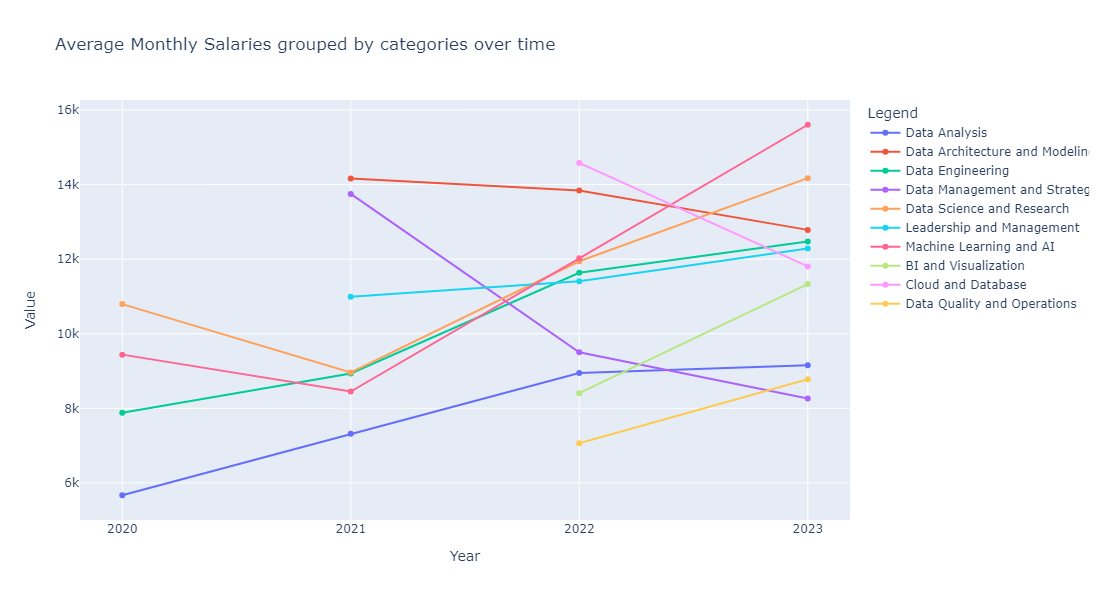

In [12]:
fig = go.Figure()

# Plot each series with a specified color
for name in salary_data.columns:
    fig.add_trace(go.Scatter(x=salary_data.index, y=salary_data[name], mode='lines+markers', name=name))

# Update layout
fig.update_layout(title="Average Monthly Salaries grouped by categories over time",
                  xaxis_title="Year",
                  yaxis_title="Value",
                  legend=dict(title="Legend"),
                  width=1100,
                  height=600)

# Show the plot
fig.show()

In [14]:
fig.write_html("avg_monthly_salaries.html")

In [11]:
salary_data

category,Data Analysis,Data Architecture and Modeling,Data Engineering,Data Management and Strategy,Data Science and Research,Leadership and Management,Machine Learning and AI,BI and Visualization,Cloud and Database,Data Quality and Operations
2020,5668.0,NaN,7881.0,NaN,10795.0,NaN,9440.0,NaN,NaN,NaN
2021,7318.0,14162.0,8933.0,13750.0,8960.0,10991.0,8450.0,NaN,NaN,NaN
2022,8949.0,13841.0,11636.0,9502.0,11945.0,11408.0,12024.0,8406.0,14583.0,7064.0
2023,9154.0,12786.0,12473.0,8261.0,14173.0,12286.0,15606.0,11332.0,11806.0,8781.0


In [ ]:
salary_data.index

In [ ]:
# # Load world map data
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# 
# # Let's assume you have a DataFrame df with columns 'country' and 'average_salary'
# data['country'] = data['country'].map(lambda x: world[world['name'] == x]['iso_a3'])
# 
# # Plot the map
# fig, ax = plt.subplots()
# world.plot(column='average_salary', ax=ax, legend=True)
# plt.show()

In [ ]:
data